In [1]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from skimage import io, color, filters, measure
import pickle as pkl
import yaml

import sys
sys.path.insert(0, "/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/measure_metrics")
from compute_metrics import *

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from itertools import combinations

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


**Function to compute Tanimoto distance between drug molecules**

In [2]:
def compute_tanimoto_distance_from_df(df):
    """
    Computes Tanimoto distance between all pairs of SMILES strings in a DataFrame.

    Parameters:
    - df: DataFrame with SMILES strings in a column.

    Returns:
    - distances_df: DataFrame containing Tanimoto distances between all pairs of SMILES strings.
    """

    # Convert SMILES strings to RDKit Mol objects
    mols = [Chem.MolFromSmiles(smiles) for smiles in df['SMILES']]

    # Calculate fingerprints for each molecule
    fps = [AllChem.GetMorganFingerprint(mol, 2) for mol in mols]

    # Compute Tanimoto distance between all pairs of fingerprints
    distances = []

    similarity_df = pd.DataFrame(index=df.index, columns=df.index)
    for i, j in combinations(range(len(df)), 2):
        tanimoto_similarity = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        similarity_df.at[df.index[i], df.index[j]] = tanimoto_similarity
        similarity_df.at[df.index[j], df.index[i]] = tanimoto_similarity
    return similarity_df.fillna(1.0)

**Util functions**

In [3]:
def initialize_model(yaml_config, dest_dir):
    args_rdkit = OmegaConf.create(yaml_config)
    dataloader_rdkit = CellDataLoader(args_rdkit)
    solver_rdkit = IMPAmodule(args_rdkit, dest_dir, dataloader_rdkit)
    return solver_rdkit

class Args:
    def __init__(self, dictionary):
        self.__dict__ = dictionary

    def __getattr__(self, key):
        if key in self.__dict__:
            return self.__dict__[key]
        else:
            raise AttributeError(f"'DictToObject' object has no attribute '{key}'")

    def __call__(self, key):
        return self.__getattr__(key)


def t2np(t, batch_dim=False):
    return ((t.permute(0, 2, 3, 1) + 1) / 2).clamp(0, 1).cpu().numpy()


def plot_n_images(images, n_to_plot, channel=None, size=((1.5, 1.5))):
    for i, img in enumerate(images):
        plt.figure(figsize=size)
        if channel == None:
            plt.imshow(img)
        else:
            plt.imshow(img[:,:,channel],"grey")
        plt.axis("off")
        plt.grid("off")
        plt.show()
        if i == n_to_plot:
            break

def transform_by_emb(solver, dataloader, y, n_average, args):
    """
    Transform images in a dataloader using a solver for a specific drug ID.

    Parameters:
        solver: The solver object used for transformation.
        dataloader: The dataloader containing images to be transformed.
        n_average (int): Number of times to average random noise vectors.
        drug_id (str): The ID of the drug for transformation.
        args: Arguments object containing additional parameters.

    Returns:
        tuple: A tuple containing two NumPy arrays representing controls and transformed images.
    """
    controls = []
    transformed = []
    y = y.unsqueeze(0)
    with torch.no_grad():
        for batch in tqdm(dataloader.train_dataloader()):
            X_ctr = batch["X"][0]
            z = torch.randn(X_ctr.shape[0], n_average, args.z_dimension).cuda().mean(1)
            # z = torch.randn(X_ctr.shape[0], n_average, args.z_dimension).cuda().quantile(0.75,0)
            
            # Perturbation ID 
            y_emb = y.repeat((z.shape[0], 1)).cuda()
            y_emb = torch.cat([y_emb, z], dim=1)
            y_emb = solver.nets.mapping_network(y_emb) 
            
            _, X_generated = solver.nets.generator(X_ctr, y_emb)
            transformed.append(t2np(X_generated.detach().cpu()))
            controls.append(t2np(X_ctr.detach().cpu()))
            break
    return np.concatenate(controls, axis=0), np.concatenate(transformed, axis=0)

def corrcoef(a, b):
    c = np.cov(a, b)
    d = np.diag(c)
    return c / np.sqrt(d[:, None] * d[None, :])

**Collect drug embeddings**

In [4]:
bbbbc021_embeddings = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/embeddings/csv/emb_fp.csv", index_col=0)

bbbc021_index = pd.read_csv("/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/data/bbbc021_unannotated/processed/bbbc021_unannotated_large/metadata/bbbc021_unannotated_large.csv")
mol2moa = {mol:y for mol, y in zip(bbbc021_index["CPD_NAME"], bbbc021_index["ANNOT"])}

In [5]:
bbbbc021_embeddings = bbbbc021_embeddings.loc[bbbbc021_embeddings.index.isin(np.unique(bbbc021_index.CPD_NAME))]

In [6]:
ood_drugs = ["taxol", 
             "ALLN", 
             "bryostatin", 
             "simvastatin", 
             "MG-132", 
             "methotrexate", 
             "colchicine", 
             "cytochalasin B", 
             "AZ258", 
             "cisplatin"]

In [7]:
ood_drug_embeddings = bbbbc021_embeddings.loc[ood_drugs]
ood_drug_embeddings = bbbbc021_embeddings
ood_moa = [mol2moa[mol] for mol in ood_drugs]

In [8]:
metadata = pd.read_csv("/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/data/bbbc021_unannotated/processed/bbbc021_unannotated_large/metadata/bbbc021_unannotated_large.csv", 
                      index_col=0)
metadata = metadata.loc[metadata.CPD_NAME.isin(bbbbc021_embeddings.index)]

metadata_unique = metadata[["CPD_NAME", "SMILES"]]
metadata_unique = metadata_unique.drop_duplicates(subset="CPD_NAME").set_index("CPD_NAME", drop=True)

tanimoto_distance_matrix = compute_tanimoto_distance_from_df(metadata_unique)

tanimoto_distance_matrix.loc[ood_drugs]
mat_tani_second_highest_val = tanimoto_distance_matrix.apply(lambda row: row.nlargest(2).iloc[-1], axis=1)
mat_tani_second_highest_cpd = tanimoto_distance_matrix.apply(lambda row: row.nlargest(2).index[-1], axis=1)

mat_tani_second_highest_ood = mat_tani_second_highest_val.loc[ood_drugs]

In [9]:
concat = pd.concat([mat_tani_second_highest_cpd, mat_tani_second_highest_val], axis=1)
concat.columns = ["Closest compound", "Tanimoto Similarity"]

In [10]:
for cpd_name, close_cpd, tani in zip(concat.index,concat["Closest compound"], concat["Tanimoto Similarity"]):
    print(cpd_name[0].upper()+cpd_name[1:], "&", close_cpd[0].upper()+close_cpd[1:], "&", np.round(tani,2), r"\\")

ALLN & MG-132 & 0.55 \\
Alsterpaullone & PD-169316 & 0.28 \\
Anisomycin & Cytochalasin D & 0.25 \\
Bryostatin & Docetaxel & 0.23 \\
Camptothecin & Alsterpaullone & 0.23 \\
Chlorambucil & Methotrexate & 0.21 \\
Cisplatin & Chlorambucil & 0.03 \\
Colchicine & Demecolcine & 0.85 \\
Cyclohexamide & Mevinolin/lovastatin & 0.2 \\
Cytochalasin B & Cytochalasin D & 0.54 \\
Cytochalasin D & Cytochalasin B & 0.54 \\
Demecolcine & Colchicine & 0.85 \\
Docetaxel & Taxol & 0.73 \\
Emetine & Demecolcine & 0.32 \\
Epothilone B & Latrunculin B & 0.21 \\
Etoposide & Demecolcine & 0.22 \\
Floxuridine & Cyclohexamide & 0.18 \\
Lactacystin & ALLN & 0.25 \\
Latrunculin B & Cytochalasin B & 0.22 \\
Methotrexate & Chlorambucil & 0.21 \\
Mevinolin/lovastatin & Simvastatin & 0.78 \\
MG-132 & Proteasome inhibitor I & 0.58 \\
Mitomycin C & Anisomycin & 0.16 \\
Mitoxantrone & Chlorambucil & 0.15 \\
Nocodazole & Alsterpaullone & 0.22 \\
PD-169316 & Alsterpaullone & 0.28 \\
PP-2 & PD-169316 & 0.19 \\
Proteasome inh

In [11]:
ood_drugs = ["Taxol", 
             "ALLN", 
             "Bryostatin", 
             "Simvastatin", 
             "MG-132", 
             "Methotrexate", 
             "Colchicine", 
             "Cytochalasin B", 
             "AZ258", 
             "Cisplatin"]

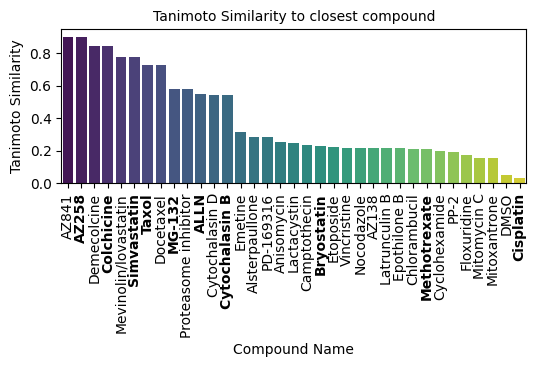

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example ood_drugs list (replace with your actual list)
# ood_drugs = ['DrugA', 'DrugB', 'DrugC']  # replace with your actual drug names

# Capitalize drug names if they are not already in uppercase
new_names = []
for name in mat_tani_second_highest_val.index:
    if name.isupper():
        new_name = name
    else:
        split_name = name.split(" ")
        if len(split_name) == 1:
            new_name = split_name[0].capitalize()
        else:
            new_name = " ".join([name.split(" ")[0].capitalize(), name.split(" ")[1]])
    
    new_names.append(new_name)

mat_tani_second_highest_val.index = new_names

# Sort the Series by the values in descending order
sorted_series = mat_tani_second_highest_val.sort_values(ascending=False)

plt.figure(figsize=(6,2))
# Create the bar plot using Seaborn, flipping it horizontally
sns.barplot(x=sorted_series.index, y=sorted_series.values, palette='viridis')

# Set labels and title
plt.xlabel('Compound Name', fontsize=10)
plt.ylabel('Tanimoto Similarity', fontsize=10)
plt.title('Tanimoto Similarity to closest compound', fontsize=10)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Bold the labels for the OOD drugs
ax = plt.gca()  # Get the current axis
for tick_label in ax.get_xticklabels():
    if tick_label.get_text() in ood_drugs:
        tick_label.set_fontweight('bold')

plt.savefig('/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/tanimoto_sim.svg',
           dpi=300, bbox_inches='tight', format='svg')

# Show plot
plt.show()



Initialize model

In [13]:
# path_to_configs = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/config_hydra/config")

# with open(path_to_configs / 'bbbc021_all_retrain_fp.yaml', 'r') as IMPA_bbbc021:
#     # Load YAML data using safe_load() from the file
#     yaml_IMPA_bbbc021 = yaml.safe_load(IMPA_bbbc021)
#     yaml_IMPA_bbbc021["z_dimension"] = 64
#     yaml_IMPA_bbbc021["style_dim"] = 128

# dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240227_aae7c2c6-b1a5-4c2a-851b-0c672502c090_bbbc021_all_retrain_fp"

# args = OmegaConf.create(yaml_IMPA_bbbc021)
# dataloader = CellDataLoader(args)
# IMPA_bbbc021 = initialize_model(yaml_IMPA_bbbc021, dest_dir)

# IMPA_bbbc021._load_checkpoint(150)

In [14]:
# path_to_configs = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/config_hydra/config")

# with open(path_to_configs / 'bbbc021_all_retrain.yaml', 'r') as IMPA_bbbc021:
#     # Load YAML data using safe_load() from the file
#     yaml_IMPA_bbbc021 = yaml.safe_load(IMPA_bbbc021)
#     yaml_IMPA_bbbc021["z_dimension"] =64
#     yaml_IMPA_bbbc021["style_dim"] = 128

# dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240227_d40b5518-ce58-4cb0-87a2-f97ac3bd7ce7_bbbc021_all_retrain"

# args = OmegaConf.create(yaml_IMPA_bbbc021)
# dataloader = CellDataLoader(args)
# IMPA_bbbc021 = initialize_model(yaml_IMPA_bbbc021, dest_dir)

# IMPA_bbbc021._load_checkpoint(150)

In [15]:
res_file_fp_path = "/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/measure_metrics/comparison_mol2image/results/eval_metrics_ckpt.ckpt"

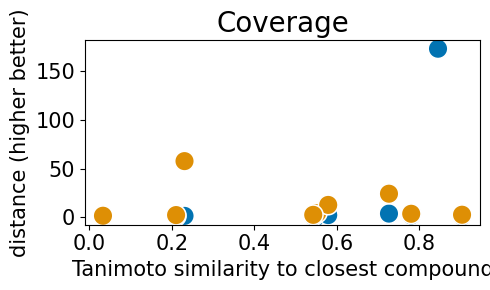

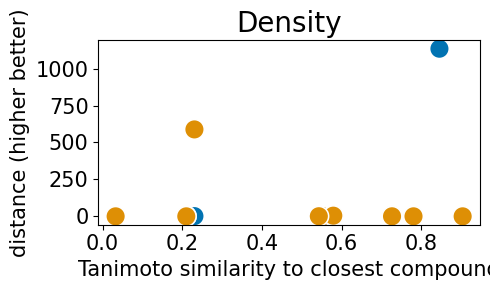

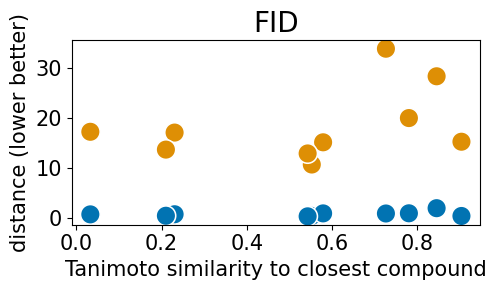

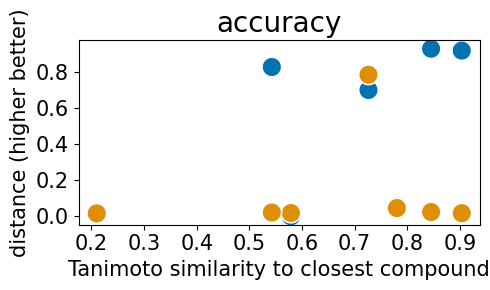

In [16]:
with open(res_file_fp_path, "rb") as file:
    res_file_fp = pkl.load(file)
res_file_fp = res_file_fp.set_index("mol")
res_file_fp = res_file_fp.replace({"1-Accuracy": "accuracy"})
res_file_fp["Correlation closest compound"] = mat_tani_second_highest_ood.loc[res_file_fp.index]
res_file_fp = res_file_fp

for score in np.unique(res_file_fp.score_type):
    res_file_fp_score = res_file_fp.loc[res_file_fp.score_type==score]
    if score=="accuracy":        
        res_file_fp_score = res_file_fp_score.loc[res_file_fp_score.index.isin(["taxol", 
                                                             "AZ258", 
                                                             "cytochalasin B", 
                                                             "colchicine", 
                                                             "simvastatin", 
                                                             "methotrexate",
                                                             "MG-132"])]
    # plt.figure(figsize=(5, 4))  # Adjust figure size
    
    # Create regplot
    plt.figure(figsize=(5,3))

    sns.scatterplot(data=res_file_fp_score, 
            x="Correlation closest compound",
            y="score",
            s=200,
            hue="model", 
            palette="colorblind", 
            legend=False, ci=0)
    
    # Title and labels with adjusted font sizes
    plt.title(score, fontsize=20)
    plt.xlabel("Tanimoto similarity to closest compound", fontsize=15)
    rank = "(higher better)" if score in ["Density", "Coverage", "accuracy"] else "(lower better)"
    plt.ylabel(f"distance {rank}", fontsize=15)
    
    # Adjust ticks font size
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    # Show plot with tight layout
    plt.tight_layout()

    plt.savefig(f"/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/{score}_vs_tanimoto.svg",
           dpi=300,format='svg')
    plt.show()

### Recompute metrics 

In [17]:
correlated = ['taxol', 'AZ258', 'cytochalasin B', 'colchicine']
non_correlated = ['simvastatin', 'ALLN', 'bryostatin', 'MG-132',"methotrexate", "cisplatin"]

In [18]:
scores = pd.read_pickle('/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/measure_metrics/comparison_mol2image/results/eval_metrics_ckpt.ckpt')

In [19]:
scores.loc[scores.model=="IMPA"]

,score,score_type,run,mol,model
0,0.955284,FID,0,taxol,IMPA
1,4.316781,Density,0,taxol,IMPA
2,3.807107,Coverage,0,taxol,IMPA
3,0.702351,1-Accuracy,0,taxol,IMPA
4,0.477062,FID,0,ALLN,IMPA
5,0.557754,Density,0,ALLN,IMPA
6,1.001159,Coverage,0,ALLN,IMPA
7,0.000000,1-Accuracy,0,ALLN,IMPA
8,0.804220,FID,0,bryostatin,IMPA
9,1.668768,Density,0,bryostatin,IMPA


In [20]:
scores.loc[scores.model=="mol2image"]

,score,score_type,run,mol,model
40,33.845884,FID,0,taxol,mol2image
41,0.418918,Density,0,taxol,mol2image
42,24.193548,Coverage,0,taxol,mol2image
43,0.787000,1-Accuracy,0,taxol,mol2image
44,10.731888,FID,0,ALLN,mol2image
45,0.501920,Density,0,ALLN,mol2image
46,4.408163,Coverage,0,ALLN,mol2image
47,0.029000,1-Accuracy,0,ALLN,mol2image
48,17.106914,FID,0,bryostatin,mol2image
49,588.235294,Density,0,bryostatin,mol2image


In [21]:
scores.loc[scores['score_type']=='FID', 'score'] = 1 / scores.loc[scores['score_type']=='FID', 'score']
scores.loc[scores['score_type']=='Density', 'score'] = 1 / scores.loc[scores['score_type']=='Density', 'score']
scores.loc[scores['score_type']=='Coverage', 'score'] = 1 / scores.loc[scores['score_type']=='Coverage', 'score']
scores.loc[scores['score_type']=='FID', 'score_type'] = u'FID\u207B\u00B9'

scores = scores.replace({"1-Accuracy": "Accuracy"})

In [22]:
scores = scores[~np.logical_and(scores.mol=="colchicine", scores.score_type=="Density")]
scores = scores[~np.logical_and(scores.mol=="colchicine", scores.score_type=="Coverage")]
scores = scores[scores.mol.isin(correlated)]
scores = scores[scores.score_type!="Density"]
# scores = scores[~np.logical_and(scores.mol.isin(non_correlated), scores.score_type=="Accuracy")]

In [23]:
scores.groupby(["model", "score_type"]).mean()

/tmp/ipykernel_2359839/719063858.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scores.groupby(["model", "score_type"]).mean()


score  run
model     score_type               
IMPA      Accuracy    0.846558  0.0
          Coverage    0.726830  0.0
          FID⁻¹       1.575566  0.0
mol2image Accuracy    0.212500  0.0
          Coverage    0.270336  0.0
          FID⁻¹       0.051885  0.0

In [24]:
# Add average score
grouping = scores.groupby(['model'], as_index=False).mean()
grouping['score_type']='average'
grouping['mol'] = 'all'
grouping['dataset'] = grouping['model']


complete_score = pd.concat([scores, grouping])
complete_score = complete_score.loc[complete_score.mol.isin(correlated+['all'])]
complete_score = complete_score.replace('mol2image', 'Mol2Image')

complete_score = complete_score.replace({"Accuracy": "accuracy", 
                                            "Density": "density", 
                                            "Coverage": "coverage"})

/tmp/ipykernel_2359839/4236139275.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouping = scores.groupby(['model'], as_index=False).mean()


In [25]:
complete_score.groupby(["model", "score_type"]).mean()

/tmp/ipykernel_2359839/1210283977.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  complete_score.groupby(["model", "score_type"]).mean()


score  run
model     score_type               
IMPA      FID⁻¹       1.575566  0.0
          accuracy    0.846558  0.0
          average     1.078999  0.0
          coverage    0.726830  0.0
Mol2Image FID⁻¹       0.051885  0.0
          accuracy    0.212500  0.0
          average     0.169868  0.0
          coverage    0.270336  0.0

In [26]:
(1.078999 - 0.169868) / 1.078999

0.8425688995077845

In [27]:
# plt.figure(figsize=(10,7))
# ax = sns.barplot(data=complete_score,
#                 x='score_type',
#                 y='score',
#                 hue='model',
#                 palette='colorblind',
#                 orient='v')

# ax.tick_params(axis='x', rotation=25)
# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)

# plt.ylabel('metric value (higher better)', fontsize=25)
# plt.xlabel('metric type', fontsize=25)
# plt.legend(loc=2, bbox_to_anchor=(1, 1), prop={'size': 25})
# plt.title('IMPA performance on unseen drugs', fontsize=30)
# plt.savefig("/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/updated_performance_unseen.svg",
#            dpi=300,format='svg')

# plt.show()

In [28]:
complete_score

,score,score_type,run,mol,model,dataset
0,1.046809,FID⁻¹,0.0,taxol,IMPA,NaN
2,0.262667,coverage,0.0,taxol,IMPA,NaN
3,0.702351,accuracy,0.0,taxol,IMPA,NaN
24,0.496388,FID⁻¹,0.0,colchicine,IMPA,NaN
27,0.931990,accuracy,0.0,colchicine,IMPA,NaN
28,2.585051,FID⁻¹,0.0,cytochalasin B,IMPA,NaN
30,0.959491,coverage,0.0,cytochalasin B,IMPA,NaN
31,0.830395,accuracy,0.0,cytochalasin B,IMPA,NaN
32,2.174015,FID⁻¹,0.0,AZ258,IMPA,NaN
34,0.958333,coverage,0.0,AZ258,IMPA,NaN


In [29]:
[label.get_text().capitalize() if label!="FID⁻¹" else label for label in ax.get_xticklabels()]

['Az841',
 'Az258',
 'Demecolcine',
 'Colchicine',
 'Mevinolin/lovastatin',
 'Simvastatin',
 'Taxol',
 'Docetaxel',
 'Mg-132',
 'Proteasome inhibitor',
 'Alln',
 'Cytochalasin d',
 'Cytochalasin b',
 'Emetine',
 'Alsterpaullone',
 'Pd-169316',
 'Anisomycin',
 'Lactacystin',
 'Camptothecin',
 'Bryostatin',
 'Etoposide',
 'Vincristine',
 'Nocodazole',
 'Az138',
 'Latrunculin b',
 'Epothilone b',
 'Chlorambucil',
 'Methotrexate',
 'Cyclohexamide',
 'Pp-2',
 'Floxuridine',
 'Mitomycin c',
 'Mitoxantrone',
 'Dmso',
 'Cisplatin']

In [30]:
for lab in ax.get_xticklabels():
    print(lab.get_text()=="FID⁻¹")

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


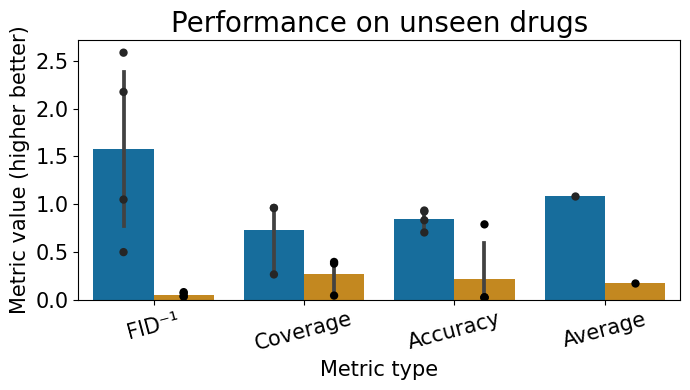

In [31]:
plt.figure(figsize=(7,4))
ax = sns.barplot(data=complete_score,
                x='score_type',
                y='score',
                hue='model',
                palette='colorblind',
                orient='v')

sns.stripplot(data=complete_score,
              x='score_type',
              y='score',
              hue='model',
              color='black',
              dodge=True,  # Separate dots for each hue category
              jitter=False,  # Keep dots aligned with bars
              marker='o',
              size=6,  # Control dot size
              ax=ax)

ax.set_xticklabels([label.get_text().capitalize() if label.get_text()!="FID⁻¹" else label for label in ax.get_xticklabels()], fontsize=15)

ax.legend_.remove()

ax.tick_params(axis='x', rotation=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylabel('Metric value (higher better)', fontsize=15)
plt.xlabel('Metric type', fontsize=15)
# plt.legend(loc=2, bbox_to_anchor=(1, 1), prop={'size': 20})
plt.title('Performance on unseen drugs', fontsize=20)

plt.tight_layout()
plt.savefig("/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/updated_performance_unseen.svg",
           dpi=300,format='svg')

plt.show()

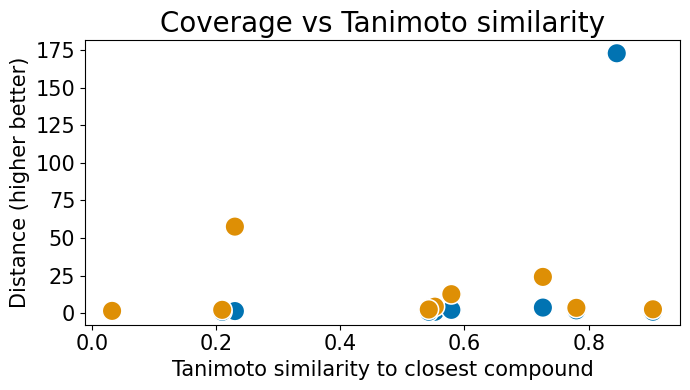

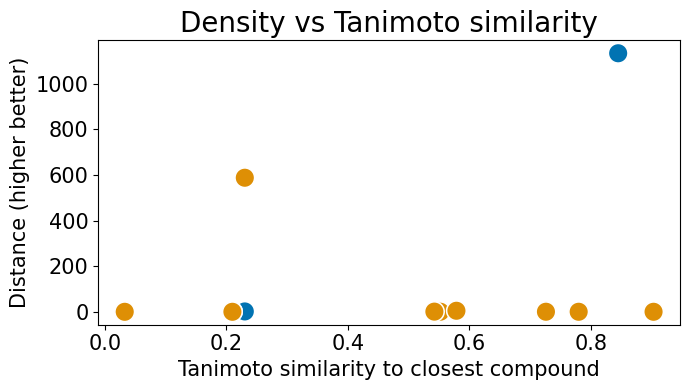

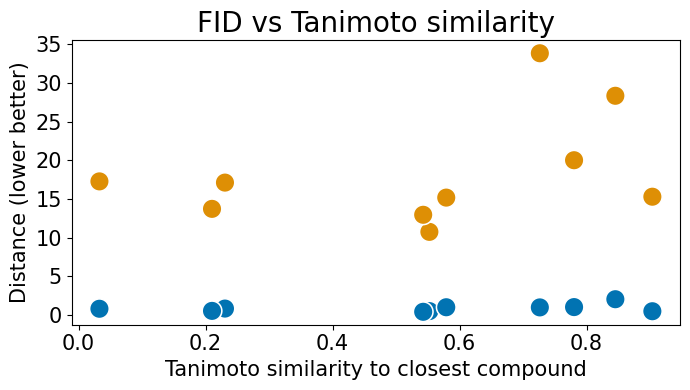

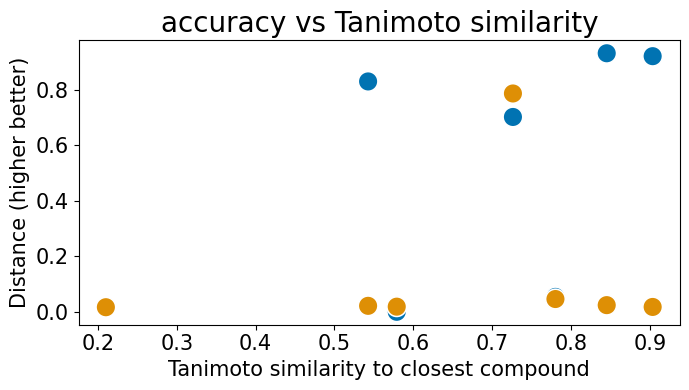

In [32]:
with open(res_file_fp_path, "rb") as file:
    res_file_fp = pkl.load(file)
res_file_fp = res_file_fp.set_index("mol")
res_file_fp = res_file_fp.replace({"1-Accuracy": "accuracy"})
res_file_fp["Correlation closest compound"] = mat_tani_second_highest_ood.loc[res_file_fp.index]
res_file_fp = res_file_fp

for score in np.unique(res_file_fp.score_type):
    res_file_fp_score = res_file_fp.loc[res_file_fp.score_type==score]
    if score=="accuracy":        
        res_file_fp_score = res_file_fp_score.loc[res_file_fp_score.index.isin(["taxol", 
                                                             "AZ258", 
                                                             "cytochalasin B", 
                                                             "colchicine", 
                                                             "simvastatin", 
                                                             "methotrexate",
                                                             "MG-132"])]
    # plt.figure(figsize=(5, 4))  # Adjust figure size
    
    # Create regplot
    plt.figure(figsize=(7,4))

    sns.scatterplot(data=res_file_fp_score, 
            x="Correlation closest compound",
            y="score",
            s=200,
            hue="model", 
            palette="colorblind", 
            legend=False, ci=0)
    
    # Title and labels with adjusted font sizes
    plt.title(f"{score} vs Tanimoto similarity", fontsize=20)
    plt.xlabel("Tanimoto similarity to closest compound", fontsize=15)
    rank = "(higher better)" if score in ["Density", "Coverage", "accuracy"] else "(lower better)"
    plt.ylabel(f"Distance {rank}", fontsize=15)
    
    # Adjust ticks font size
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    # Show plot with tight layout
    plt.tight_layout()

    plt.savefig(f"/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/{score}_vs_tanimoto.svg",
           dpi=300,format='svg')
    plt.show()

# Save `csv` files

In [35]:
complete_score.to_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/source_data/figure_2e.csv")

In [36]:
res_file_fp.loc[res_file_fp.score_type=="FID"].to_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/source_data/figure_2d.csv")

In [37]:
sorted_series.to_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/source_data/figure_2c.csv")